<b>Credit Card Project Part II: Tests and Simulations</b>

This project uses credit card data for 30,000 anonymous credit card clients in Taiwan. It presents information on the customers (education, sex, marital status, age) and information about customer behavior for a six-month period from April 2005 to September 2005. [The information was downloaded in CSV format from Kaggle](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset), and it was uploaded from the UC Irvine Machine Learning Repository.

In order to keep the amount of information manageable, I have split the project into two parts. [<b>Part I</b>](https://github.com/dr-mentaculus/Credit_Card_Project/blob/main/credit_card_Part_I.ipynb) focuses on Machine Learning algorithms and Feature Engineering. <b>Part II</b>, presented here, provides an opportunity to practice running statistical tests and simulations. [<b>Part III</b>](https://github.com/dr-mentaculus/Credit_Card_Project/blob/main/credit_card_Part_III.ipynb) trains a model that sacrifices performance for interpretability. [**Part IV**](https://github.com/dr-mentaculus/Credit_Card_Project/blob/main/credit_card_part_IV.ipynb) is a less serious project, and is basically me playing around with simulations and plotting.

[**PowerPoint summaries of the projects**](https://www.dropbox.com/sh/38tcjlw7gb7bvka/AABsPtsNWq7yXZpuBqO1-_qNa?dl=0) are also avaiable.

<b>Goals</b>


From project I in this series, evidence has that women are flagged as risky customers at a higher rate than men. This interpretation of the evidence rests on a further interpretation of the nature of the dataset, that it is a sample not of customers in general, *but of customers who have been flagged as at risk of default*. I will explain and argue for this interpretation in a moment.

Assuming that women are being flagged at a higher rate, I run numerous tests to see if there are good business reasons for doing so. Do the women in the dataset default at the same rate or higher than the men, for example, or are they more likely to have missed a payment. However, in every respect, the women in the dataset seem to be less risky customers, and to a highly statistically significant degree. This provides potentially useful information. The credit card company should either flag fewer women, or flag more men. (Which option is better depends on whether unnecessarily flagging a customer, or failing to identify a risky customer in advance, is more costly.)

Before proceeding with the project, a few further issues should be addressed.

<b>Does the Data Represent a Random Sample?</b>

The short answer is, I do not know. There is good evidence that the dataset is not a random sample of the credit card customers in general. Over 22% of the customers in the dataset defaulted after a six-month period. Moreover, the median customer has a debit balance equal to at least 1.4x their credit limit. If this represents a random selection of 30,000 credit card customers, the credit card company does not seem long for this world. (The evidence is presented in more detail in [Part I of the project](https://github.com/dr-mentaculus/Credit_Card_Project/blob/main/credit_card_Part_I.ipynb).)

My working assumption is that the data represents a random sample of customers who have been flagged as a credit risk. The high default rate and percentage of customers who have exceeded their credit limit are evidence for this interpretation. But there could be something even stranger going on. Any conclusions drawn about this data should be regarded as provisional, and in real life, more would need to be done to confirm the data's credibility.

Note that the concern that women are being flagged as default risks at a higher rate than men rests on this working assumption. Women make up more than 60% of the sample customers, so if this is a random sample of customers judged risky, there is good reason to think women are being flagged at a higher rate. But if this is not a random sample at all, the interpetation would turn out to be unwarranted.

<b>Inadvertent P-Hacking?</b>

I end up performing a total of 7 statistical tests on the dataset in the course of *this project and project IV*. This raises the risk, however, of inadvertent p-hacking. Assuming we set $\alpha$ to .05 in all cases, and the null hypothesis is true in each case, the chance of generating at least one false positive turns out to be $\approx$ 30.2%.

There is a more subtle problem as well. The decision about which tests to perform is not being made prior to looking at the data: I am deciding in many cases to perform tests because something about the data looks surprising.

The first problem can be solved by lowering the value of $\alpha$. If $\alpha = .007$, the chance of producing at least false positive by random chance, assuming the null hypotheses are true in every case, is $\approx$ .048. Because the datasets are large, low p-values should not be hard to come by.

With respect to the second problem, I will assume here that the purpose of the statistical tests is exploratory: that is, statistically significant results indicate what should be the targets of a second study, in which the tests to perform have been determined in advance.

As a way of capturing that within the limitations of this project, I will randomly split the dataset into two parts: an exploratory set of 10,000 samples, and a test set of 20,000 samples.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

#starting_data = pd.read_csv("https://github.com/dr-mentaculus/Credit_Card_Project/blob/main/UCI_Credit_Card.csv?raw=True")

starting_data = pd.read_csv("UCI_Credit_Card.csv")

starting_data.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


<b>Some Information on the Columns</b>

The following information about the columns was provided to accompany the Kaggle Dataset. 

(<b>Note</b>: I am only providing information about a few of the columns here. Please see Part 1 for a complete description.)

• LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit

• SEX: Gender (1=male, 2=female)

• EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

• MARRIAGE: Marital status (1=married, 2=single, 3=others)

• AGE: Age in years

• default.payment.next.month: Default payment (1=yes, 0=no)

In [3]:
#Separating out subsample of 10000 for exploratory testing.

hermetically_sealed_data = starting_data.sample(n=20000, replace=False, random_state=211)

starting_data = starting_data[~starting_data.index.isin(hermetically_sealed_data.index)]

len(hermetically_sealed_data), len(starting_data)

(20000, 10000)

<b>Basic Exploratory and Descriptive Statistics</b>

The following cells provide basic descriptive information about some of the relations in the dataset. More interesting statistical tests will come later.

In [4]:
#Renaming categories to make results more readable

df = starting_data[["LIMIT_BAL",
                    "SEX", "EDUCATION", "MARRIAGE", "AGE", "default.payment.next.month"]].copy()

df.SEX.replace({1: "male", 2: "female"}, inplace=True)
df["SEX"] = pd.Categorical(df.SEX)

df.EDUCATION.replace({0: "other_1", 1: "postgraduate", 2: "undergraduate", 3: "secondary", 4: "other_2",
                     5: "other_4", 6: "other_5"}, inplace=True)

df["EDUCATION"] = pd.Categorical(df.EDUCATION, ordered=True, 
                                 categories = ["postgraduate", "undergraduate", "secondary", "other_1", "other_2",
                                               "other_4", "other_5"])

df.MARRIAGE.replace({1: "married", 2: "single", 3: "divorced", 0: "other"}, inplace=True)
df["MARRIAGE"] = pd.Categorical(df.MARRIAGE, ordered=True,
                               categories = ["married", "single", "divorced", "other"])

df.rename(columns={"default.payment.next.month":"defaulted"}, inplace=True)

In [5]:
#22.7% defaulted; 60.4% of customers are women; 

default_percent = df.defaulted.mean() * 100

sex_percent = df.SEX.value_counts()/len(df) * 100
female_percent = sex_percent["female"]
ed_percent = df.EDUCATION.value_counts()/len(df) * 100
bachelor_percent = ed_percent["undergraduate"]
grad_percent = ed_percent["postgraduate"]

string = f"""
Customer characteristics:\n
{default_percent:.1f}% of customers in the sample defaulted.
{female_percent:.1f}% are women.
{bachelor_percent:.1f}% have an undergraduate degree for their highest educational attainment.
{grad_percent:.1f}% have a postgraduate degree.
"""


print(string)



Customer characteristics:

22.7% of customers in the sample defaulted.
60.4% are women.
46.6% have an undergraduate degree for their highest educational attainment.
35.6% have a postgraduate degree.



In [6]:
#wide distribution heavily skewed by a very long right tail.

df.LIMIT_BAL.describe()

count     10000.000000
mean     168937.600000
std      130323.794203
min       10000.000000
25%       50000.000000
50%      140000.000000
75%      240000.000000
max      800000.000000
Name: LIMIT_BAL, dtype: float64

In [7]:
#data contains no missing values

df.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
defaulted    0
dtype: int64

In [8]:
#comparing men and women's default rates and credit limits.

#Note that the default rate for men is about 4.9% higher. Men have (slightly) lower 
#average credit limits than women.

q25 = lambda x: x.quantile(.25)
q75 = lambda x: x.quantile(.77)
r_mean = lambda x: round(np.mean(x), 2)

a = df.groupby("SEX")["defaulted"].agg(["sum", "mean"])
a.rename(columns={"mean": "default_proportion", "sum": "number_defaulted"}, inplace=True)

b = df.groupby("SEX").LIMIT_BAL.agg(["min", q25, "median", q75, "max", r_mean])
b.rename(columns={"min": "min_limit", "<lambda_0>": "first_quartile", "median": "median_limit",
                  "<lambda_1>": "third_quartile", "max": "max_limit", "<lambda_2>": "mean_limit"}, inplace=True)

a = a.merge(b, left_index=True, right_index=True)
a

,number_defaulted,default_proportion,min_limit,first_quartile,median_limit,third_quartile,max_limit,mean_limit
SEX,,,,,,,,
female,1251,0.207051,10000.0,70000.0,150000.0,250000.0,780000.0,170951.67
male,1014,0.256190,10000.0,50000.0,140000.0,260000.0,800000.0,165863.06


<IPython.core.display.Javascript object>


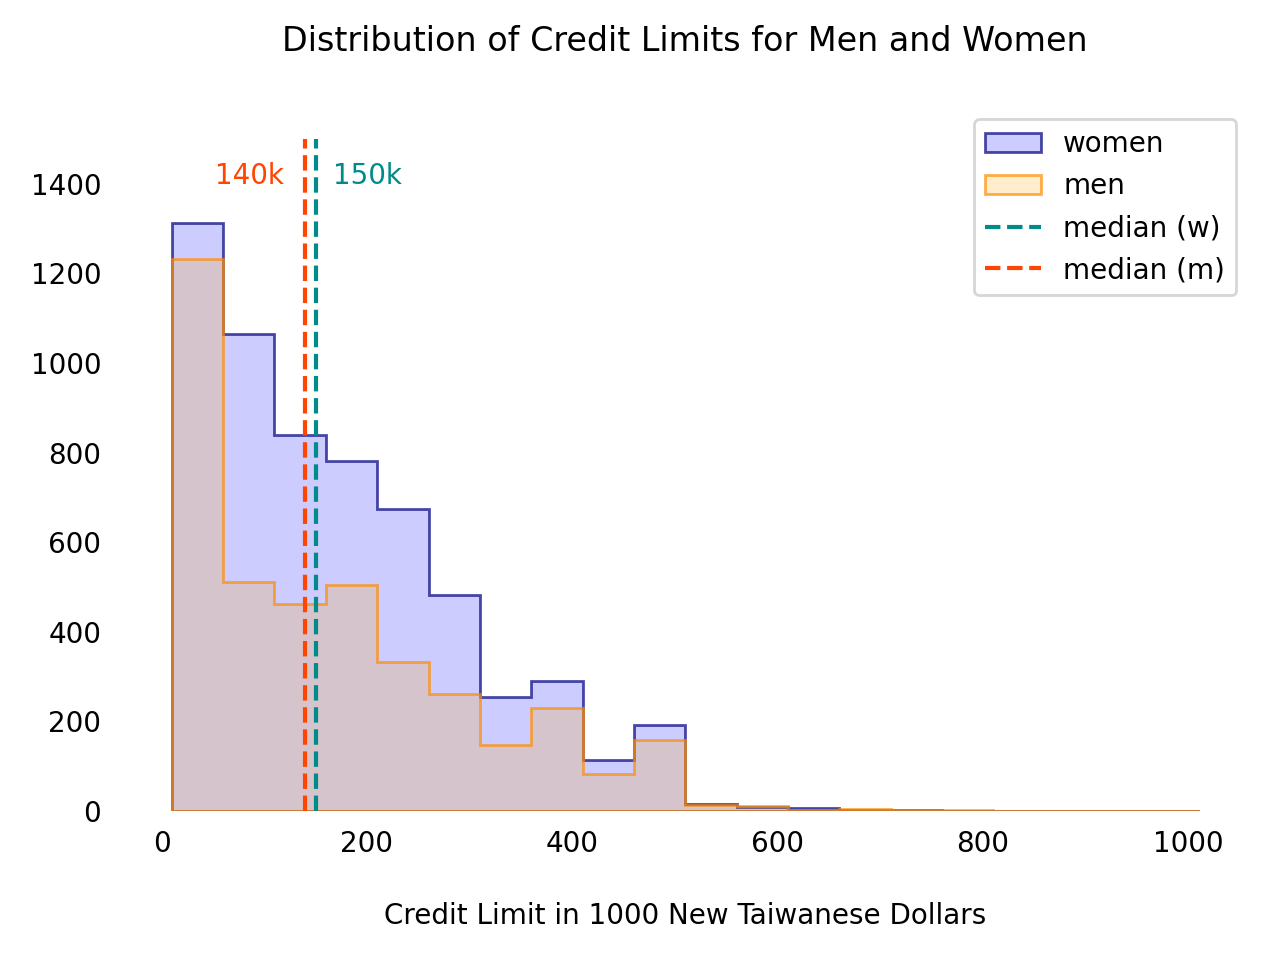

In [9]:
#plotting the distribution of men and women's credit limits
from matplotlib.colors import to_rgba


x1 = df[df.SEX == "female"].LIMIT_BAL
x2 = df[df.SEX == "male"].LIMIT_BAL

%matplotlib notebook

fig, ax = plt.subplots()

ax.hist(x1, histtype="stepfilled", facecolor=to_rgba("blue", .2), edgecolor=to_rgba("navy", .7),
        bins=range(10000, 1060000, 50000))
ax.hist(x2, histtype="stepfilled", facecolor=to_rgba("orange", .2), edgecolor=to_rgba("darkorange", .7),
        bins=range(10000, 1060000, 50000))
ax.vlines(ymin=0, ymax=1500, x=150000, color="darkcyan", linestyle="--")
ax.vlines(ymin=0, ymax=1500, x=140000, color="orangered", linestyle="--")
ax.annotate("150k", xy=(167000, 1400), color="darkcyan")
ax.annotate("140k", xy=(52000, 1400), color="orangered")
plt.legend(["women", "men", "median (w)", "median (m)"])
plt.box(False)
plt.tick_params(left=False, bottom=False)
plt.title("Distribution of Credit Limits for Men and Women\n")
ax.set_xticks([0, 200000, 400000, 600000, 800000, 1000000])
ax.set_xticklabels([0, 200, 400, 600, 800, 1000])
ax.set_xlabel("\nCredit Limit in 1000 New Taiwanese Dollars")
plt.tight_layout()

In [10]:
#How does education relate to sex?

l = pd.crosstab(df.SEX, df.EDUCATION)
l

EDUCATION,postgraduate,undergraduate,secondary,other_1,other_2,other_4,other_5
SEX,,,,,,,
female,2108,2872,968,2,33,50,9
male,1451,1783,664,5,17,33,5


In [11]:
#Considering percentages of men and women in each educational category

counts = df.SEX.value_counts()

l.loc["female"] = round(l.loc["female"]/counts["female"], 3)*100
l.loc["male"] = round(l.loc["male"]/counts["male"], 3)*100
l

EDUCATION,postgraduate,undergraduate,secondary,other_1,other_2,other_4,other_5
SEX,,,,,,,
female,34.9,47.5,16.0,0.0,0.5,0.8,0.1
male,36.7,45.0,16.8,0.1,0.4,0.8,0.1


In [12]:
#Women customers tend to be younger, but not dramatically so.

j1 = df.groupby("SEX").AGE.agg(["min", "median", "max", r_mean])
j1.columns = ["min_age", "median_age", "max_age", "mean_age"]
j1

,min_age,median_age,max_age,mean_age
SEX,,,,
female,21,33.0,74,34.93
male,21,35.0,75,36.69


In [13]:
#Again, looking at which percentages fall into which age groups.

df["age_group"] = pd.cut(df.AGE, bins=(20, 32, 44, 60, 80))
k = pd.crosstab(df.SEX, df.age_group)

#Age groupings in percent
k.loc["female"] = round(k.loc["female"]/counts["female"]*100, 1)
k.loc["male"] = round(k.loc["male"]/counts["male"] * 100, 1)

k

age_group,"(20, 32]","(32, 44]","(44, 60]","(60, 80]"
SEX,,,,
female,47.3,36.4,15.6,0.7
male,39.7,39.5,19.6,1.2


<IPython.core.display.Javascript object>


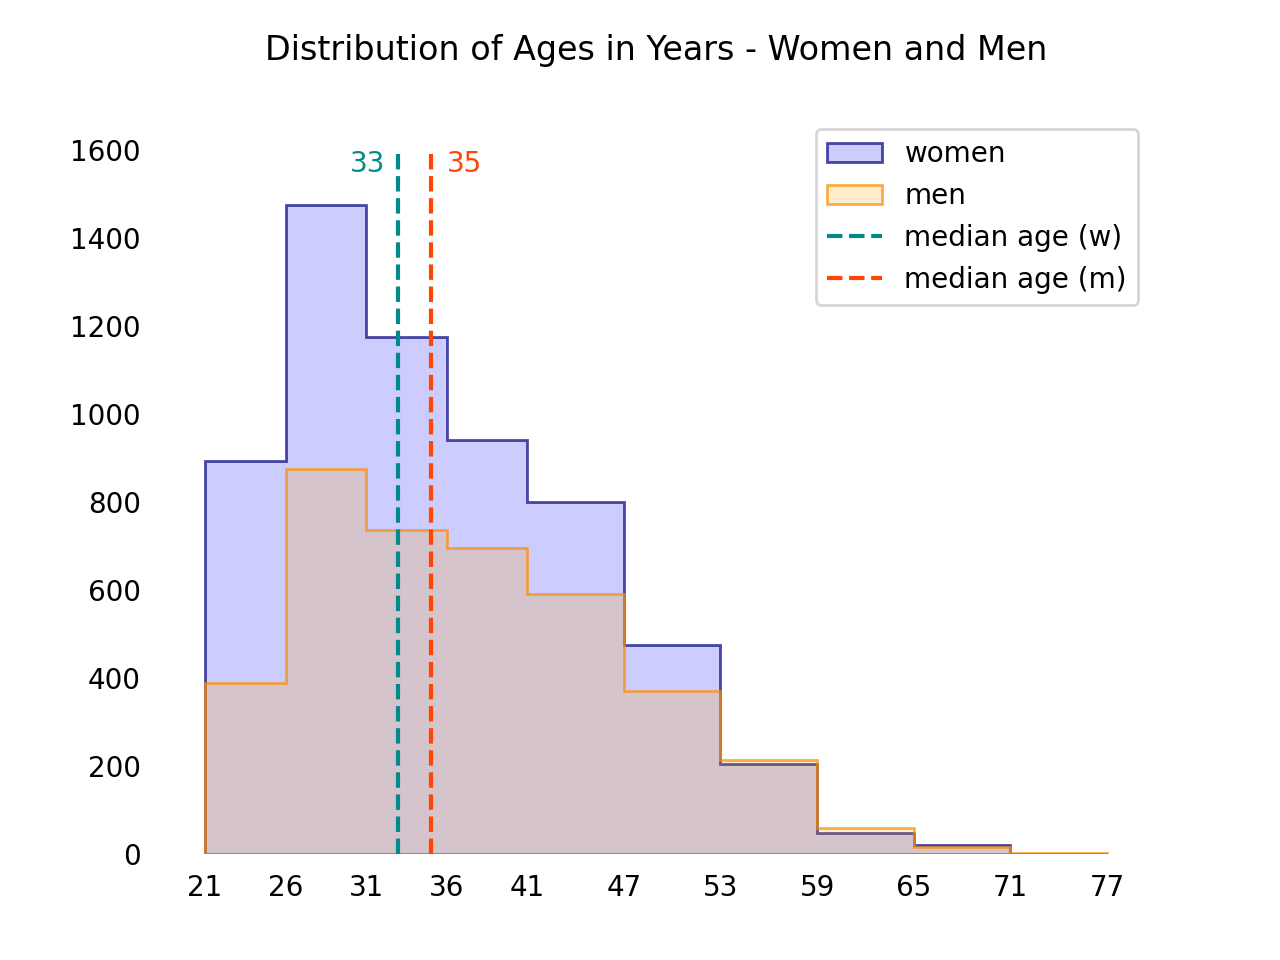

Text(0.5, 1.0, 'Distribution of Ages in Years - Women and Men\n')

In [14]:
#Plotting the distribution of ages for men and women.

x3 = df[df.SEX=="female"].AGE
x4 = df[df.SEX=="male"].AGE

fig, ax = plt.subplots()
ax.hist(x3, histtype="stepfilled", facecolor=to_rgba("blue", .2), edgecolor=to_rgba("navy", .7),
       bins=[21, 26, 31, 36, 41, 47, 53, 59, 65, 71, 77])
ax.hist(x4, histtype="stepfilled", facecolor=to_rgba("orange", .2), edgecolor=to_rgba("darkorange", .7),
       bins=[21, 26, 31, 36, 41, 47, 53, 59, 65, 71, 77])
ax.vlines(ymin=0, ymax=1600, x=33, color="darkcyan", linestyle="--")
ax.vlines(ymin=0, ymax=1600, x=35, color="orangered", linestyle="--")
ax.annotate("33", xy=(30, 1550), color="darkcyan")
ax.annotate("35", xy=(36, 1550), color="orangered")
plt.legend(["women", "men", "median age (w)", "median age (m)"])
ax.set_xticks([21, 26, 31, 36, 41, 47, 53, 59, 65, 71, 77])
plt.box(False)
plt.tick_params(left=False, bottom=False)
plt.title("Distribution of Ages in Years - Women and Men\n")

<b>Identifying Tests to Perform</b>
    
The women using the credit card tend to be slightly younger than the men. Educational attainment among the two groups is comparable. Men are slightly more likely to have postgraduate degrees; women are slightly less likely to have stopped at high school. Even if there are statistically significant differences here, the total magnitude of the differences is small.

Of more interest is simply the fact that women substantially outnumber men in this sample group: 60.4% to 39.6%. This is especially interesting if we have a random sample of customers who have been flagged as at risk, rather than a random sample of customers in general. (See the Introduction or Part I of the project for the evidence supporting this interpretation.) This raises the question, why are women being flagged as at risk at a higher rate than men.

The following section will establish (1) that the difference in the ratio of men to women is statistically significant; (2) that the differences in the likelihood of defaulting are statistically significant; (3) that women are less likely to have exceeded their credit limit or missed a payment than men.

These tests, in conjunction with the assumption that we are looking at a set of flagged customers, indicate that women are more likely to be flagged, and that this cannot be explained by a greater likelihood of defaulting, a greater chance of exceeding the credit limit, or a greater likelihood of missing a payment. The credit card company should consider revising its system for determining which customers are at risk of default.

<b>Apologies for Overkill</b>

In a few cases, the statistical tests are not really needed. It's fairly simple math to show, for example, that the percentage of women in the dataset differs from that in the general taiwanese population by a Z-score of $\approx$ 18! Part of the point of the project, though, is to practice at using SciPy's statistics software. So I will run tests to confirm that, yes, in fact, a Z-score of 18 means a very, very low p-value.

<b>Importing a Data Cleaning Function</b>
    
In order to make the data a bit easier to work with, I will import the data_processing function I wrote for this dataset for Part I of the project. The function will also add a column to the dataset, "total_proportions", which records how much debt the customer has accumulated in the six-month period, as a multiple of their credit limit (i.e., anything over 1 means the customer has exceeded their credit limit)

**Note, this means if you want to run this code yourself, you also need to download classes_n_functions and import the data_cleaning function from that file. (Alternately, you can copy and paste the code for the function in the cell below.)**

In [15]:

#51.0% of women in the dataset have exceeded their credit limit in the recorded period. 59.2%
#of men have exceeded their credit limit.

from ipynb.fs.defs.classes_n_functions import data_processing

X, y = data_processing(starting_data)

np.mean(X[X.sex==1].total_proportions>1), np.mean(X[X.sex==0].total_proportions>1)

(0.5099304865938431, 0.5922182920667004)

In [16]:
#6042 women in total
np.sum(X.sex)

6042

**99.3% Confidence Interval**

Since $\alpha\$ has been set at .007, we should calculate .993 Confidence Intervals, to maintain symmetry.

**z-scores** for .997 CI: +/- 2.697.

In [67]:
#Could the discrepancy in the percentage of men and women simply reflect random sampling?

z_score = (X.sex.mean() - .515)/X.sex.sem()

CI = [X.sex.mean() - 2.697 * X.sex.sem(),
      X.sex.mean(), X.sex.mean() + 2.697 * X.sex.sem()]


results = st.binomtest(k=6042, n=10000, p=.515)


print(f"""
According to Wikipedia (https://en.wikipedia.org/wiki/Demographics_of_Taiwan), women make up 
approximately 51.5% of the population of Taiwan. Assuming as our null hypothesis that the
percentage of women in the sampled population is the same as the general population we get
the following results:

Z-score of observed population = {z_score:.2f}
p-value = {results.pvalue:.2g}

Given our sample size and observed the proportion of women, we can say that women make up 
between {CI[0]:.3f} and {CI[2]:.3f} of the sampled population with 99.3% Confidence. In other
words, the proportion of women in the sampled population is about {(CI[0]-.515)*100:.2f}% 
to {(CI[2]-.515)*100:.2f}% higher than in the population at large.
""")


According to Wikipedia (https://en.wikipedia.org/wiki/Demographics_of_Taiwan), women make up 
approximately 51.5% of the population of Taiwan. Assuming as our null hypothesis that the
percentage of women in the sampled population is the same as the general population we get
the following results:

Z-score of observed population = 18.24
p-value = 7.5e-72

Given our sample size and observed the proportion of women, we can say that women make up 
between 0.591 and 0.617 of the sampled population with 99.3% Confidence. In other
words, the proportion of women in the sampled population is about 7.60% 
to 10.24% higher than in the population at large.



In [68]:
#How statistically significant is the difference in the default rates?

a = df[df.SEX=="female"]["defaulted"]
b = df[df.SEX=="male"]["defaulted"]


results2 = st.ttest_ind(b, a, random_state=16, equal_var = False, alternative="greater")

print(f"""
{100*a.mean():.1f}% of women in the sample defaulted. {100*b.mean():.1f}% of men defaulted.

A one-sided t-test confirms that men from the sampled population are more likely than 
women to default, and the difference in the sample is extremely unlikely to have arisen from
random chance(p = {results2.pvalue:.2g}).
""")


20.7% of women in the sample defaulted. 25.6% of men defaulted.

A one-sided t-test confirms that men from the sampled population are more likely than 
women to default, and the difference in the sample is extremely unlikely to have arisen from
random chance(p = 7.8e-09).



<b>Running Simulations to determine the Confidence Interval of the Difference</b>

I will first calculate the confidence interval, then run a simulation to double-check the results. If there is significant difference, I will go with the more conservative range (i.e, the wider confidence interval). Again, we are using a .997 CI.

In [69]:
#getting the standard error.

def standard_error_difference(pop1, pop2):
    return (pop1.var()/len(pop1) + pop2.var()/len(pop2))**.5

In [70]:
se = standard_error_difference(a, b)
se

0.008679549989298907

In [71]:
#calculating the confidence interval

t_val = st.t.ppf(.9965, df=(len(a)+len(b)-2))

CI0 = b.mean() - a.mean() - t_val*se
CI1 = b.mean() - a.mean() + t_val*se

print(f"""
Using a t_distribution with 9998 degrees of freedom, the .993 confidence interval for the
difference in the two proportions ranges from {CI0:.3f} to {CI1:.3f}.
""")


Using a t_distribution with 9998 degrees of freedom, the .993 confidence interval for the
difference in the two proportions ranges from 0.026 to 0.073.



In [72]:
#simulation to determine variance in means

gaps = np.zeros(10000)

for i in range(10000):
    
    gap = (b.sample(frac=1, replace=True, random_state=(5*i)).mean()-
           a.sample(frac=1, replace=True, random_state=(13*i)).mean())
    gaps[i] = gap

CI = [np.quantile(gaps, .0035), np.quantile(gaps, .9965)]

print(f"""After 10,000 simulations, the estimated 997% confidence interval for the difference
in the proportion of customers to default in the two sampled populations is [{CI[0]:.3f},
{CI[1]:.3f}].""")

After 10,000 simulations, the estimated 997% confidence interval for the difference
in the proportion of customers to default in the two sampled populations is [0.026,
0.073].


<b>Results Match</b>

Yay.

<IPython.core.display.Javascript object>


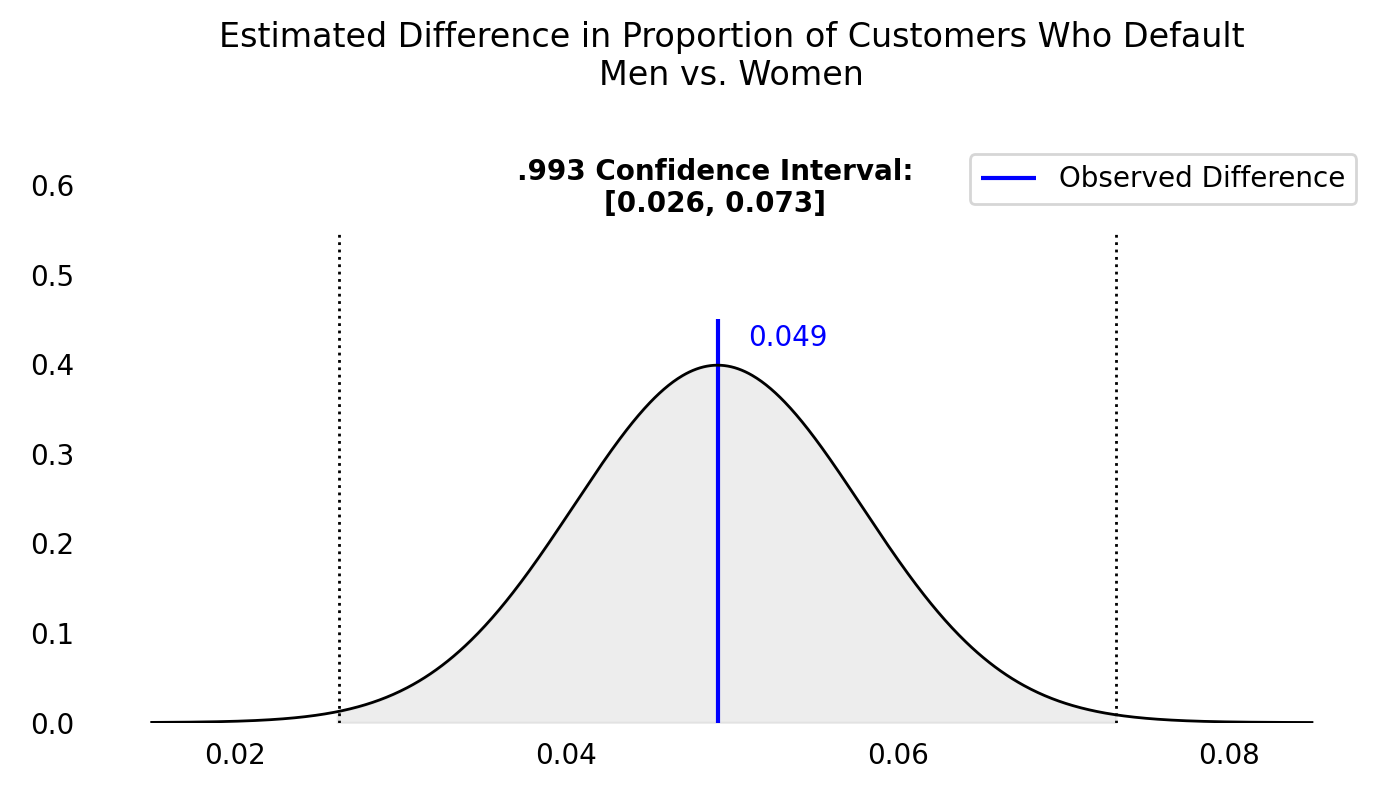

In [93]:
#practice plotting confidence intervals

x = np.linspace(.015, .085, 1000)
x_norm = (x-(b.mean()-a.mean()))/se
y = st.t.pdf(x_norm, df=9998)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x, y, color="black", linewidth=1)
ax.set_frame_on(False)
ax.set_ylim(0, .65)
ax.tick_params(bottom=False, left=False)
ax.set_xticks([.02, .04, .06, .08])
ax.vlines(ymin=0, ymax=.55, x=CI[0], color="black", linestyle=":", linewidth=1)
ax.vlines(ymin=0, ymax=.55, x=CI[1], color="black", linestyle=":", linewidth=1)
ax.vlines(ymin=0, ymax=.45, x=b.mean()-a.mean(), color="blue",
         label="Observed Difference")
x_fill = x[(x>=.0262)&(x<=.0732)]
y_fill = y[(x>=.0262)&(x<=.0732)]
ax.fill_between(x=x_fill, y1=0, y2=y_fill, color="lightgray", alpha=.4)
ax.annotate(".993 Confidence Interval:\n[0.026, 0.073]", xy=(.049, .57)
            , weight="bold", ha="center")
ax.annotate(f"{(b.mean()-a.mean()):.3f}", xy=(.051, .42), color="blue")
ax.set_ylabel("")
plt.tick_params(bottom=False, left=False)
plt.title("Estimated Difference in Proportion of Customers Who Default\nMen vs. Women\n")
plt.box(False)
ax.legend()
plt.tight_layout()
#plt.savefig("ci_simulations.png", dpi=300)

<b>How Big Is the Difference?</b>

Men almost certainly default at a higher rate than women in the sampled population. But how substantial is the difference in the rate of default? Much of this depends on whether we are looking at a random sample of all customers, or a random sample of customers who have been flagged as risky. On the former interpretation, this may not be that interesting. Women make up a larger portion of the company's customer base. But women also appear to be more reliable users of credit, so the imbalance makes sense. The credit card company's real problem is that close to a quarter of customers end up defaulting.

If this is a sample of flagged customers, the difference in default rates appears substantial. We can put the point like this. The current system for flagging customers seems to flag women at a rate disproportionate to their actual likelihood of defaulting. How disproportionate? For the women in our sample to be defaulting at the same rate as the men, we would need to see approximately 19.2% of the women removed from our sample, all from the subclass of those who did not default.

Some of the math is below.

In [28]:
pd.crosstab(df.SEX, df.defaulted)

defaulted,0,1
SEX,,
female,4791,1251
male,2944,1014


In [29]:
#if the number of defaulting women (1251) made up the same percentage of women as the
#percentage of men who defaulted, how many non-defaulting women would there be?
#4883

1251/(b.mean())

4883.094674556213

In [30]:
#How many fewer women would be in our sample?
np.sum(df.SEX=="female") - 4883

1159

In [31]:
#What percentage of women would be losing from our sample?

1159/np.sum(df.SEX=="female")

0.1918238993710692

In [32]:
#What percentage of the sample would be women?

4883/(4883 + np.sum(df.SEX=="male"))

0.552313086754892

<b>Explanations</b>

I will here consider two possible explanations of the dispartiy in the number of women and men in our sample (again on the assumption that this represents a sample of flagged customers). Even if the women in our sample default at a lower rate than men, there may be other aspects of their customer behavior which made it reasonable to worry they would default. For example, it may be that more of the women have exceeded their credit limit, or missed a payment.

We will see below that men in the sample wrack up larger deficits in the six-month period, measured as a proportion of their credit limit. And men exceed their credit limit at a higher rate.

<b>Proportionate Debt</b>

The chart below looks at how indebted men and women are, with the size of the deficit between their bills and their payment in the six month period, given as a multiple of their credit limit. Notice that the majority of customers in the sample have more debt than their credit limit. A possible explanation for this is given in Part I of the project. (Briefly, new spending may have been cut off, but the customers may be continuing to wrack up more debt as a result of fines and penalties.)

<IPython.core.display.Javascript object>


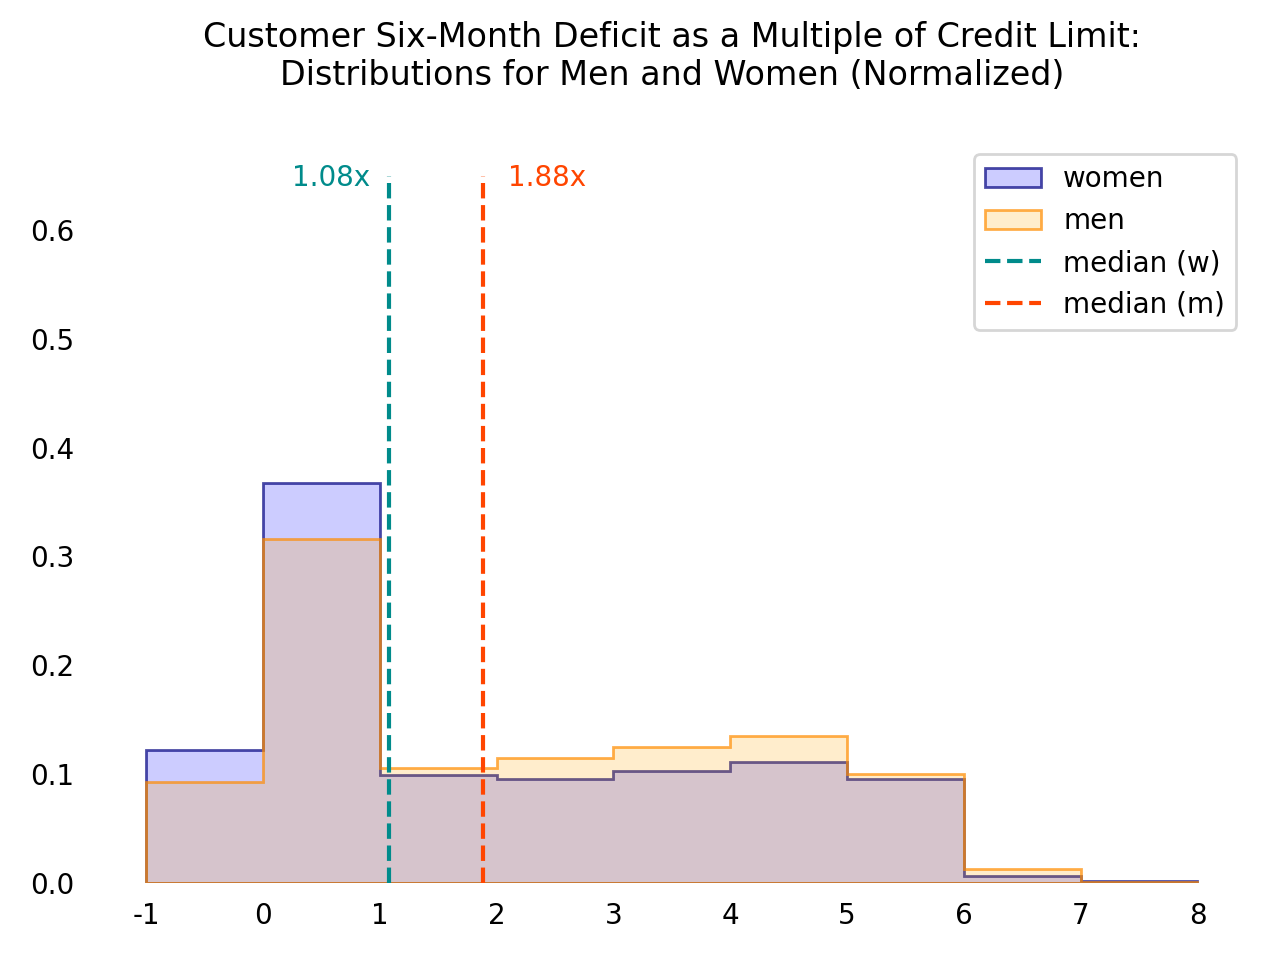

In [33]:
#plotting the proportional differences

x5 = X[X.sex==1].total_proportions
x6 = X[X.sex==0].total_proportions

fig, ax = plt.subplots()

bins = np.arange(-1, 9, 1)

ax.hist(x5, bins=bins, density=True, histtype="stepfilled",
        facecolor=to_rgba("blue", .2), edgecolor=to_rgba("navy", .7))
ax.hist(x6, bins=bins, density=True, histtype="stepfilled",
        facecolor=to_rgba("orange", .2), edgecolor=to_rgba("darkorange", .7))
ax.vlines(ymin=0, ymax=.65, x=x5.median(), color="darkcyan", linestyle="--")
ax.vlines(ymin=0, ymax=.65, x=x6.median(), color="orangered", linestyle="--")
ax.annotate(f"{x5.median():.2f}x", xy=(.25, .64), color="darkcyan")
ax.annotate(f"{x6.median():.2f}x", xy=(2.1, .64), color="orangered")
ax.set_xticks(bins)
ax.set_xticklabels(bins)
plt.legend(["women", "men", "median (w)", "median (m)"])
plt.title("Customer Six-Month Deficit as a Multiple of Credit Limit:\nDistributions for Men and Women (Normalized)\n")
plt.box(False)
plt.tick_params(left=False, bottom=False)
plt.tight_layout()
#plt.savefig("mw_proportional_debt.png", dpi=300)

In [34]:
#testing statistical significance of difference in medians.

results = st.median_test(x5, x6)

print(f"""
According to Mood's median test, the difference in the value of the medians is statistically
significant (p=({results[1]:.2g})).
""")


According to Mood's median test, the difference in the value of the medians is statistically
significant (p=(1.7e-14)).



<b>Running a Simulation to Estimate Confidence Intervals</b>

Rather than looking up how one calculates the confidence interval for a difference in medians, I will run another simulation to estimate confidence intervals for the difference.

In [78]:
men_med = np.zeros(10000)
wom_med = np.zeros(10000)

for i in range(10000):
    men_med[i] = x6.sample(frac=1, replace=True, random_state=4*(i+14)).median()
    wom_med[i] = x5.sample(frac=1, replace=True, random_state=5*(i+7)).median()

diff = men_med - wom_med
men_ci = [np.quantile(men_med, .0035), np.quantile(men_med, .9965)]
wom_ci = [np.quantile(wom_med, .0035), np.quantile(wom_med, .9965)]
diff_ci = [np.quantile(diff, .0035), np.quantile(diff, .9965)]
pval1 = np.mean(men_med > wom_med)

print(f"""
After running 10,000 bootstrapping simulations, the median value of men's debt as a
proportion of their credit limit exceeded the median value of women's debt as a proportion
of their credit limit in {pval1*100:.2f}% of cases. The median proportion of men's debt ran
from {np.min(men_med):.2f} times their credit limit to {np.max(men_med):.2f} times their
credit limit. Women's median proportional debt ranged {np.min(wom_med):.2f} to {np.max(wom_med):.2f}.

Based on these simulations, the estimated 99.3% confidence interval of the difference in the 
median values ranges from {diff_ci[0]:.2f} to {diff_ci[1]:.2f}. In other words, the median
woman from the sampled population would need additional debt equal to 52% to 105% of her
credit limit to have proportional debt equal to that of the median man.
""")


After running 10,000 bootstrapping simulations, the median value of men's debt as a
proportion of their credit limit exceeded the median value of women's debt as a proportion
of their credit limit in 100.00% of cases. The median proportion of men's debt ran
from 1.60 times their credit limit to 2.13 times their
credit limit. Women's median proportional debt ranged 0.87 to 1.35.

Based on these simulations, the estimated 99.3% confidence interval of the difference in the 
median values ranges from 0.52 to 1.05. In other words, the median
woman from the sampled population would need additional debt equal to 52% to 105% of her
credit limit to have proportional debt equal to that of the median man.



<IPython.core.display.Javascript object>


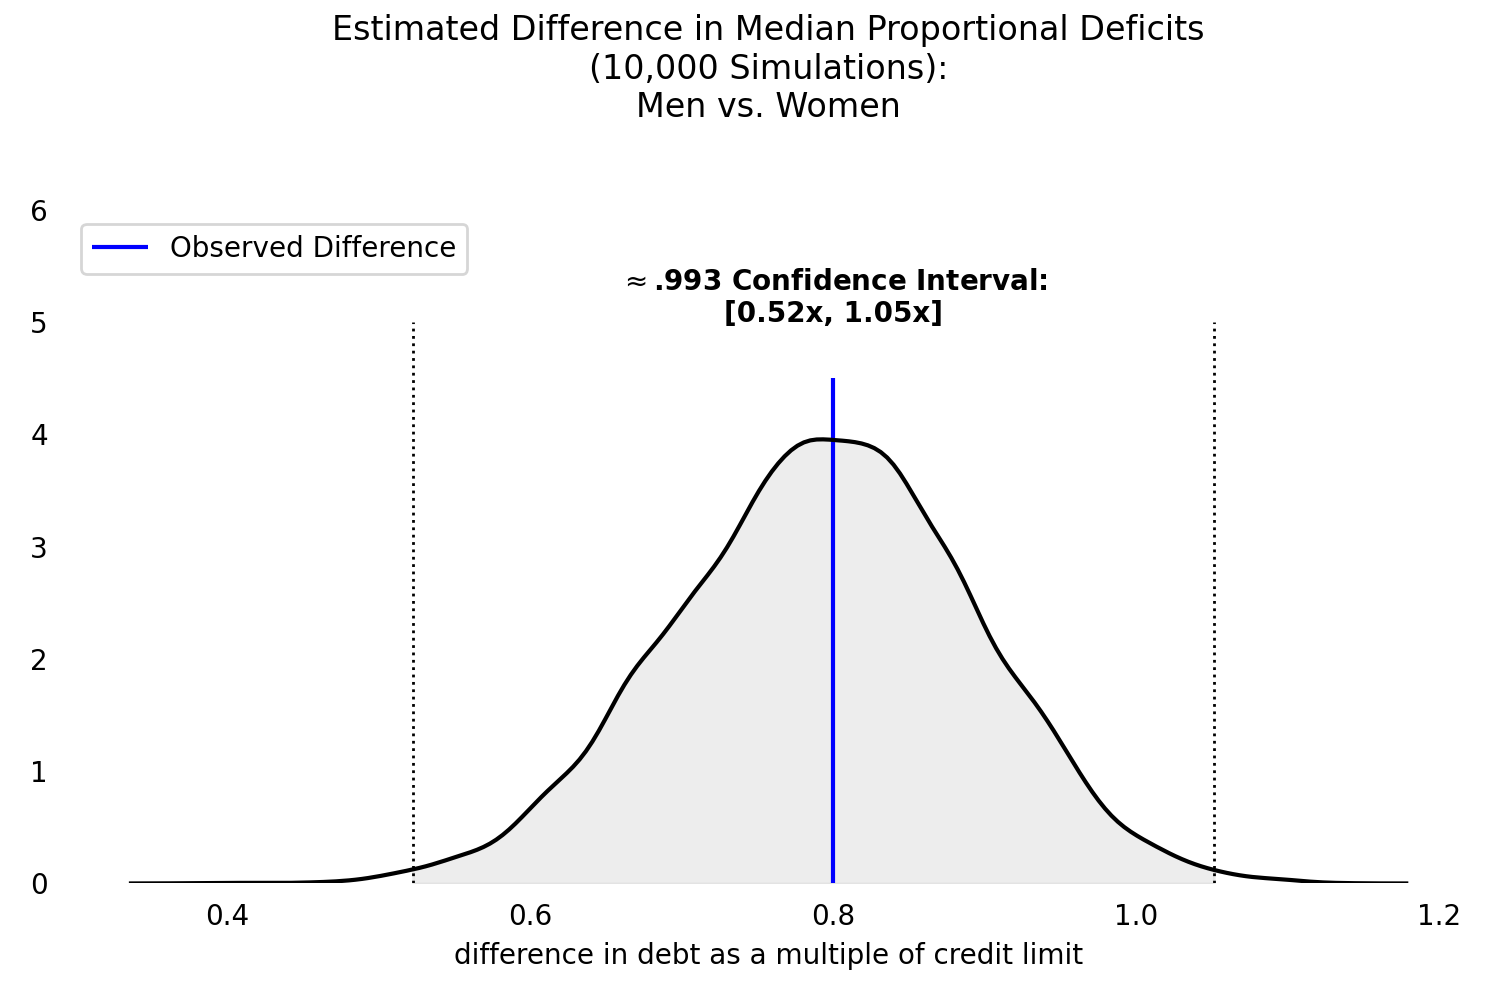

In [94]:
#plotting the confidence interval

fig, ax = plt.subplots(figsize=(7.5, 5))

kde2 = sns.kdeplot(diff, color="black")
ax.vlines(ymin=0, ymax=5, x=diff_ci[0], color="black", linestyle=":", linewidth=1)
ax.vlines(ymin=0, ymax=5, x=diff_ci[1], color="black", linestyle=":", linewidth=1)
ax.vlines(ymin=0, ymax=4.5, x=.8, color="blue", label="Observed Difference")
line2 = kde2.lines[0]
x2, y2 = line2.get_data()
x2_fill = x2[(x2>diff_ci[0])&(x2-.003<diff_ci[1])]
y2_fill = y2[(x2>diff_ci[0])&(x2-.003<diff_ci[1])]
ax.fill_between(x=x2_fill, y1=0, y2=y2_fill, color="lightgray", alpha=.4)
ax.set_ylim(bottom=0, top=6)
ax.annotate("$\\approx$.993 Confidence Interval:\n[0.52x, 1.05x]", xy=(.8, 5), weight="bold",
           ha="center")
plt.box(False)
plt.tick_params(left=False, bottom=False)
plt.title("Estimated Difference in Median Proportional Deficits\n(10,000 Simulations):\nMen vs. Women\n\n")
ax.set_ylabel("")
ax.set_xlabel("difference in debt as a multiple of credit limit")
ax.legend(loc="upper left")
plt.tight_layout()
#plt.savefig("median_diff.png", dpi=300)

Men in the sample have, on average, exceeded their credit limit by a much higher proportion than women. I will run a further test, comparing the proportion of men who fall into at least one group it would be reasonable to flag--exceeding their credit limit, missing a payment, or defaulting--and comparing that to the proportion of women who fall into at least one of these groups. Again, it turns out that men in the sample population are much more likely to fall into at least one of these groups than women.

In [38]:
#building a contingency table.

X["defaulted"] = df.defaulted.copy()

X["missed_payment"] = X[[f"PAY_{N}" for N in range(1,7)]].sum(axis=1).astype(bool)

X["over_limit"] = (X.total_proportions >=1)

X_chi = X[["sex", "missed_payment", "over_limit", "defaulted"]].copy()

X_chi.sex.replace({1: "female", 0: "male"}, inplace=True)

X_chi["flagged"] = (X.missed_payment)|(X.over_limit)

d = pd.crosstab(X_chi.sex, X_chi.flagged)
d

flagged,False,True
sex,,
female,2174,3868
male,1122,2836


In [39]:
#Same data, but in percentage form

d1 = d.copy()

d1.loc["female"] = d1.loc["female"]/counts["female"]
d1.loc["male"] = d1.loc["male"]/counts["male"]

d1

flagged,False,True
sex,,
female,0.359815,0.640185
male,0.283477,0.716523


In [40]:
#Men are also more likely to have missed a payment than women.

X[X.sex==0].missed_payment.mean(), X[X.sex==1].missed_payment.mean()

(0.3610409297625063, 0.31231380337636544)

In [41]:
stat, p, dof, expected = st.chi2_contingency(d)

print(f"""
64.0% of women in the sample group belong to at least one flagged category, compared to 71.7%
of men.

A chi-square test confirms that this difference is statistically signficant (p={p:.2g}).
""")


64.0% of women in the sample group belong to at least one flagged category, compared to 71.7%
of men.

A chi-square test confirms that this difference is statistically signficant (p=2.4e-15).



<b>Could Uncertainty Be the Explanation</b>

One final possibility to rule out is that exceeding one's credit limit or missing a payment are less predictive for men than women. It could be that men display obvious risk factors at a higher rate than women, and default at a higher rate. But it could still be true that women are more likely to default *without prior warning*, that is, without first missing a payment or exceeding the credit limit.

I will compare the rates of default among "unflagged" men and women to see if this might explain some of the discrepancy.

In [42]:
unflagged = X_chi[~X_chi.flagged]

pd.crosstab(unflagged.sex, unflagged.defaulted)

defaulted,0,1
sex,,
female,1919,255
male,963,159


In [43]:
#Unflagged men appear, in fact, to be at greater risk of defaulting than unflagged women.

255/(1919+255), 159/(963+159)

(0.11729530818767249, 0.14171122994652408)

<b>Conclusion</b>

By looking at a disjunction of flagged categories, we may explain <b>some of</b> the discrepancy in the proportion of men and women (again assuming that this is a sample of customers flagged as risky). Men are more likely to fall into at least one of the high-risk categories than women are. But the magnitude of the proportional difference is smaller. As noted above, for the men and women in our samples to have the same rate of default, the number of women would need to go down by about 19.2%, all from the category of non-defaultees. In order for the proportion of sampled men and women in a high-risk category to be equal, the number of women in our sample would need to be 10.7% lower.

But this is still a noticeable difference, even if it is a smaller one. Again, on the assumption that the data represents a sample of high-risk customers, the company may wish to revise how it identifies these customers. In the current data, it appears to be responding to customer risk inconsistently.

Once again, some of the math is below.

In [44]:
(df.SEX=="female").sum()

6042

In [45]:
#Number of women in flagged group, divided by *proportion* of men in flagged group.

3868/.717

5394.700139470015

In [46]:
#How many women fewer would be in our sample.

6042-5395

647

In [47]:
#Getting the percentage.

647/6042

0.10708374710360807

<b>Summing up the results.</b>

Out of four tests, all four had statistically significant results, relative to $\alpha = .007$. (Remember, $\alpha$ was set this low to prevent inadvertent p-hacking on this project and project IV.)

<b>Validating the results</b>

What remains below is epilogue. I will run the four tests on the remaining 20,000 cases to verify the conclusions reached earlier.

In [48]:
X_sealed, y_sealed = data_processing(hermetically_sealed_data)

X_sealed["defaulted"] = y_sealed

X_sealed["missed_payment"] = X_sealed[[f"PAY_{N}" for N in range(1,7)]].sum(axis=1).astype(bool)

X_sealed["over_limit"] = (X_sealed.total_proportions >=1)

df_final = X_sealed[["sex", "total_proportions", "defaulted", "missed_payment", "over_limit"]].copy()

In [49]:
#Women make up 60.4% of this sample, compared to 60.4% in the original sample.

np.mean(df_final.sex), np.sum(df_final.sex)

(0.6035, 12070)

In [50]:
#Binomial Test confirms statistical significance

st.binomtest(k=12070, n=20000, p=.515)

BinomTestResult(k=12070, n=20000, alternative='two-sided', proportion_estimate=0.6035, pvalue=1.362107333375191e-139)

In [51]:
#Checking .95 Confidence Interval

[df_final.sex.mean() - 1.96 * df_final.sex.sem(), df_final.sex.mean() + 1.96 * df_final.sex.sem()]

[0.596720273659323, 0.6102797263406771]

<b>Comparing proportions who default.</b>

There is still a statistically significant difference in the proportion of men and women who default (p=5.3e-6).

However, difference is a notably smaller than in our previous subsample. In the previous sample 20.7% of women  defaulted and 25.6% of men.

Results this extreme happened in the simulations with a frequency of .0089, or in less than 1% of simulations. Similarly, using the t-distribution we would expect results this extreme with a probability of .0089.

This is still within our very wide .993 CI, but just barely.

In [52]:
#23.4% of men in the larger sample defaulted, compared to 20.8% of women.

c, d = df_final[df_final.sex==0].defaulted, df_final[df_final.sex==1].defaulted

np.mean(c), np.mean(d)

(0.23442622950819672, 0.20811930405965204)

In [53]:
#that's a difference of 2.6%.

diff = np.mean(c) - np.mean(d)
diff

0.026306925448544682

In [54]:
#The difference in the proportion of defaultees in each group from this sample is fairly 
#surprising, given the previous sample. Results this extreme happened in less than 1% of
#simulations.

np.mean((gaps <= diff)|(gaps >= .049 + (.049-diff)))

0.0089

In [55]:
#Let's see how unlikely results like this are, using the t-distribution, and the assumption
#that the previous subsample reflects what the population is actually like.

t = (.049-diff)/se
t

2.6145450604505776

In [56]:
#Again, p = .0089. This is pretty much the same as in the simulations.

(1 - st.t.cdf(t, df=19998))*2

0.008941337182270415

<IPython.core.display.Javascript object>


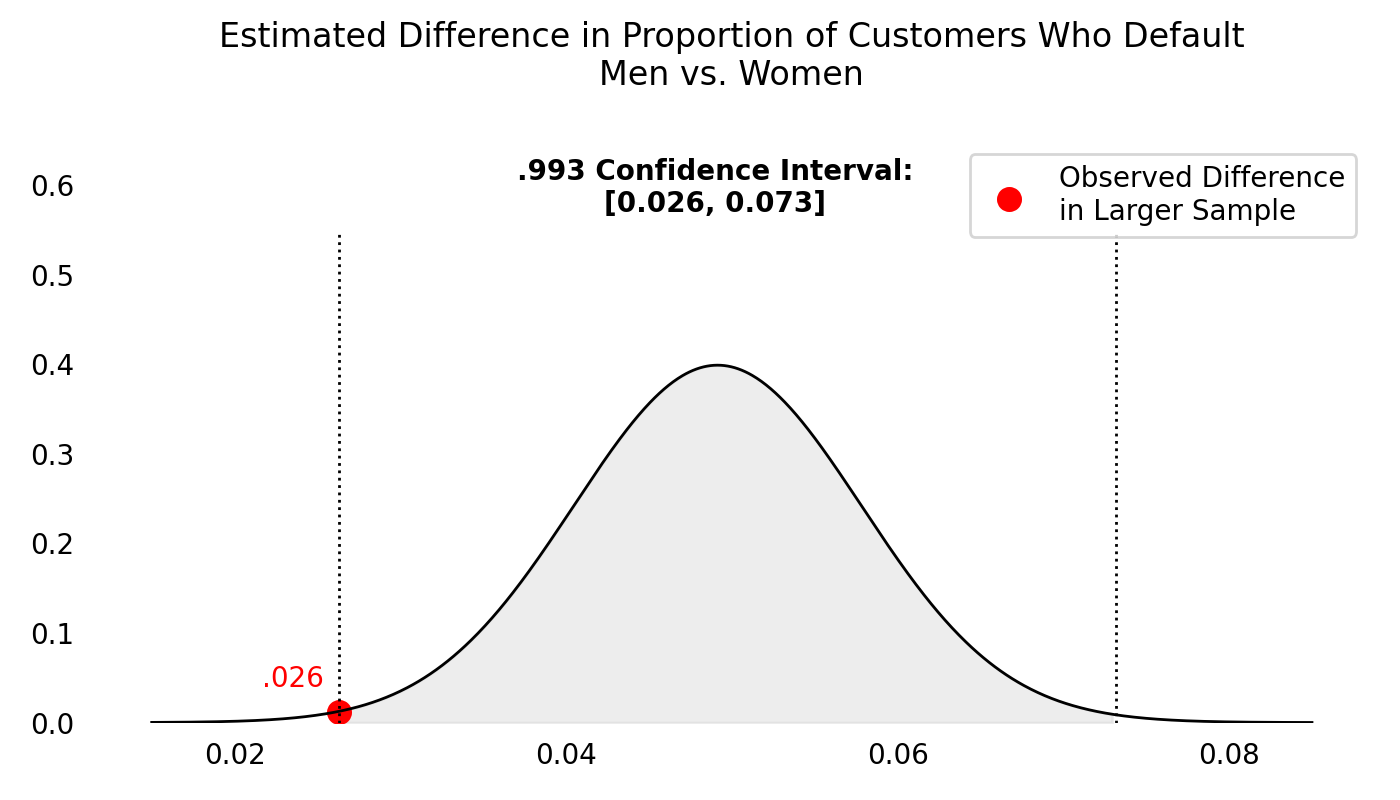

In [95]:
#plotting a visual aide.

x = np.linspace(.015, .085, 1000)
x_norm = (x-(b.mean()-a.mean()))/se
y = st.t.pdf(x_norm, df=9998)

y_new = y[(x>.02595)&(x<.02605)]

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x, y, color="black", linewidth=1)
ax.set_frame_on(False)
ax.set_ylim(0, .65)
ax.tick_params(bottom=False, left=False)
ax.set_xticks([.02, .04, .06, .08])
ax.vlines(ymin=0, ymax=.55, x=CI[0], color="black", linestyle=":", linewidth=1)
ax.vlines(ymin=0, ymax=.55, x=CI[1], color="black", linestyle=":", linewidth=1)
#ax.vlines(ymin=0, ymax=.45, x=b.mean()-a.mean(), color="blue",
         #label="Observed Difference in First Subsample")
x_fill = x[(x>=.026)&(x<=.073)]
y_fill = y[(x>=.026)&(x<=.073)]
ax.fill_between(x=x_fill, y1=0, y2=y_fill, color="lightgray", alpha=.4)
ax.scatter([.0263], y_new, color="red", linewidth=3, label="Observed Difference\nin Larger Sample")
ax.annotate(".993 Confidence Interval:\n[0.026, 0.073]", xy=(.049, .57)
            , weight="bold", ha="center")
ax.annotate(".026", xy=(.0235, .04), color="red", ha="center", )
ax.set_ylabel("")
plt.tick_params(bottom=False, left=False)
plt.title("Estimated Difference in Proportion of Customers Who Default\nMen vs. Women\n")
plt.box(False)
ax.legend()
plt.tight_layout()
#plt.savefig("outside_ci.png", dpi=300)

In [55]:
#checking statistical significance of the observed difference.

st.ttest_ind(c, d, alternative="greater")

Ttest_indResult(statistic=4.40563244513364, pvalue=5.301188253317826e-06)

<b>Deviation from Expected Results</b>

While more men in this second sample group than women, the difference is notably smaller than what was observed in the previous sample. The ultimate discrepancy in how men and women are being flagged as credit-risks, if that is what is happening, may be less pronounced.

In [56]:
#Checking Median Indebtedness as Proportion of Credit Limit
#Notice that in this case the difference in median proportional debt is very close to that in the previous sample:
#0.80 vs. 0.86. This is well within our previous .95 confidence interval of [.60, .98].

df_men = df_final[df_final.sex==0]
df_women = df_final[df_final.sex==1]

df_men.total_proportions.median(), df_women.total_proportions.median()

(1.8693664705882354, 1.0937803571428573)

In [57]:
#this difference is statistically significant, unsurprisingly

st.median_test(df_men.total_proportions, df_women.total_proportions)

(112.88187548255186,
 2.2902057709959928e-26,
 1.421665,
 array([[4333, 5667],
        [3597, 6403]]))

In [58]:
#Checking the difference in likelihood of missing a payment or exceeding one's limit.

df_final["flagged"] = ((df_final.over_limit)|(df_final.missed_payment))

last_table = pd.crosstab(df_final.sex, df_final.flagged)

last_table

flagged,False,True
sex,,
0,2328,5602
1,4269,7801


In [59]:
#Same data in percentage form

fin_counts = df_final.sex.value_counts()

percents = last_table.copy()

for x in last_table.index:
    percents.loc[x] = percents.loc[x]/fin_counts[x]

percents

flagged,False,True
sex,,
0,0.293569,0.706431
1,0.353687,0.646313


In [60]:
#Once again, the difference is statistically significant.

st.chi2_contingency(last_table)

(77.97612584871366,
 1.042935047681423e-18,
 1,
 array([[2615.7105, 5314.2895],
        [3981.2895, 8088.7105]]))

In [61]:
#How many women would be in our no-default group if the proportions of default were equal?
#11050

7801/.706

11049.575070821531

In [62]:
12070-11050

1020

In [63]:
#That means 8.5% fewer women in the subsample.

1020/12070

0.08450704225352113

In [1]:
11050/(18980)

0.5821917808219178

<b>Checking Rates of Default Among Unflagged Men and Women</b>

In [65]:
final_check = df_final[~df_final.flagged]

pd.crosstab(final_check.sex, final_check.defaulted)

defaulted,0,1
sex,,
0,2061,267
1,3767,502


In [66]:
#Rates of default among unflagged men and women are basically the same. Remember, we 
#are looking to see if unflagged women pose a GREATER risk than unflagged men, to 
#explain the discrepancy in how they seem to wind up on this list
#of risky customers (assuming that is what it is). They do not.

267/(2061 + 267), 502/(3767 + 502)

(0.11469072164948453, 0.11759194190676973)

<b>Final Conclusion</b>

Assuming that this data sample represents customers who have been flagged, women are flagged at a higher rate than men, and there is a discrepancy in how likely they are to be flagged compared to obvious signs of credit risk. The discrepancy is smaller in this second, larger sample than in the original sample, however. If enough women who did not have obvious signs of risk were left out to make the risk posed by each group proportionate, the number of women in our sample would decline by about 8.5%. This suggests that the company's current method for determining who is at risk either overpredicts the risk for women, or underpredicts for men.